# Reading images
## What is Tensor:

- In Maths , one dimensional array is vector and two dimensional array is matrx.
- Tensor is array with any number of dimensions called ranks.
- A Matrxi with 12 rows and 18 colums = shape = (12,18) and rank 2.
- Use numpy to create n-dimensional arrays.
- Example:
    ```
    x = np.array([2.0, 3.0, 1.0, 0.0])  ## 1 D array
    x5d = np.zeros(shape=(4,3,7,8,3))
    ```

In [ ]:
import numpy as np
x = np.array([2.0, 3.0, 1.0, 0.0])
x.shape

(4,)

In [ ]:
### Create 5D Array of zeros
x5d = np.zeros(shape=(4,3,7,8,3))
print(x5d.shape)
print(x5d.ndim)
print(x5d.size)  ## Total number of elements
print(x5d.dtype) ## Data type of elements
print(x5d.itemsize) ## Size of each element in bytes
print(x5d.nbytes)  ## Total size in bytes (size * itemsize)

(4, 3, 7, 8, 3)
5
2016
float64
8
16128


In [ ]:
### To obtain hardware acceleration with TensorFlow, we need to install the tensorflow package.
!pip install tensorflow
import tensorflow as tf
tx = tf.convert_to_tensor(x, dtype=tf.float32)
tx.shape

TensorShape([4])

In [ ]:
## To convert tensor back to numpy array
nx = tx.numpy()
nx

### Numpy array is done on the CPU,
### while TensorFlow can utilize GPU/TPU for acceleration.

array([2., 3., 1., 0.], dtype=float32)

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
import tensorflow as tf
def read_and_decode(filename, reshape_dims):
    ## img is tensor that contains an array of bytes.
    img = tf.io.read_file(filename)
    ### Decoding - Covert image to 3D uint8 tensor
    ### 3 color channels - red,green and blue from JPEG image.
    ### Gray scale may have only one channel.
    ### The pixels consist of RGB values of type unit8
    ### unit8  = unsigned - no -ve, int integer 8 bits  (0 to 255)
    img = tf.image.decode_jpeg(img, channels=3)
    ### Covert 3D int8 to floats in the [0,1] range.
    ### coz - ML does better with small numbers.
    img = tf.image.convert_image_dtype(img, tf.float32)
    ### Covert to the Model size with which the image data will be processed.
    return tf.image.resize(img, reshape_dims)

### Lists all entries (files and directory names) under that GCS prefix. Returns a tensor or Python list of full GCS paths
### Replace the path with "" and retain only the file names.
CLASS_NAMES = [item.numpy().decode("utf-8") for item in
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/", "")]

### Removes dot . and any extensions.
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


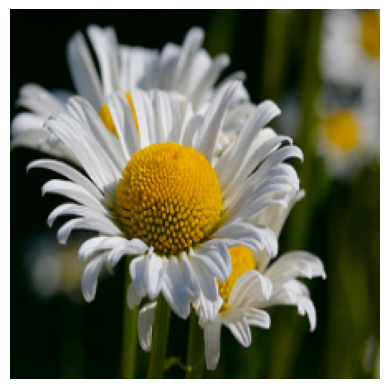

In [ ]:
# Visualization of image
def show_image(filename):
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    ## Matplotlib expects a numpy array
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_image(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/100930342_92e8746431_n.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10094729603_eeca3f2cb6.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10128546863_8de70c610d.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10163955604_ae0b830975_n.jpg


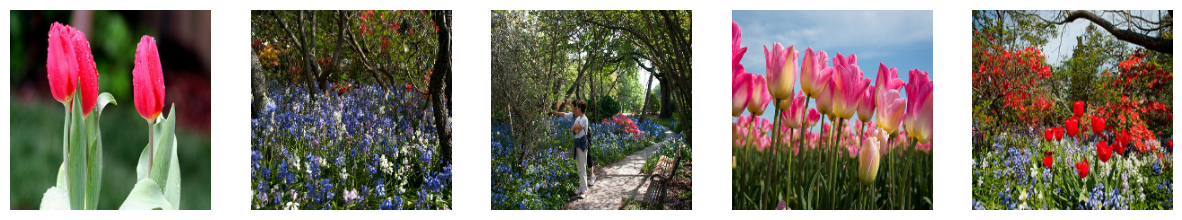

In [ ]:
# notice that the file name has the flower type in it. Let's look at a few tulips
tulips = tf.io.gfile.glob("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(tulips[:5]):
  print(filename)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis('off')

# Liner Model

In [ ]:
# ...existing code...
# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
    # record_defaults tells tf.io.decode_csv how to parse each CSV column.
    # Here we expect two string columns: the image path and the class name.
    record_defaults = ["path", "flower"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)

    # Read the image file and preprocess to fixed size and dtype [0,1].
    # read_and_decode handles decoding JPEG -> uint8, converting to float32 and resizing.
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])

    # Convert the class name string into an integer class index by comparing
    # against CLASS_NAMES. tf.math.equal returns a boolean vector; tf.argmax
    # finds the index where it is True.
    # Result is an integer tensor suitable for SparseCategoricalCrossentropy.
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))

    return img, label

# Create datasets from CSV files containing "path,classname" per line.
# Map decode_csv to get (image_tensor, label_index) pairs and batch them.
# Consider adding .shuffle(...) and .prefetch(tf.data.AUTOTUNE) for better training perf.
train_dataset = (
    tf.data.TextLineDataset(
        "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv"
    )
    .map(decode_csv)
    .batch(10)  # batch size: number of samples per gradient update
)

eval_dataset = (
    tf.data.TextLineDataset(
        "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv"
    )
    .map(decode_csv)
    .batch(10)
)

# Linear model: flatten image and apply a single Dense softmax layer
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax"),
    ]
)

# Compile model:
# - optimizer 'adam' for adaptive learning
# - loss SparseCategoricalCrossentropy because labels are integer indices (not one-hot)
# - from_logits=False because the model outputs probabilities (softmax already applied)
# - metrics=['accuracy'] to monitor classification accuracy
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training ##
Training the neural network actually means using training images and labels to adjust weights and biases so as to minimize the cross-entropy loss. The cross-entropy is a function of the model’s weights and biases, the pixels of the training image, and its known class.

## Activation ##

*   **logit**  - history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
*   **Sigmoid** - Binary classifier between 1 - 0
*  **softmax** - is multiclass couterpart of the sigmoid function. used in Dense layer in Keras with five output nodes.(Mutliclass classifier)
**

## Optimizer ##

- Stochastic gradient descent (SGD)
- Adagrad ( adaptive gradeinet) and adam
- Ftrl - To work on extremely sparse dataset with many features.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │       752,645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 752,645 (2.87 MB)

 Trainable params: 752,645 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

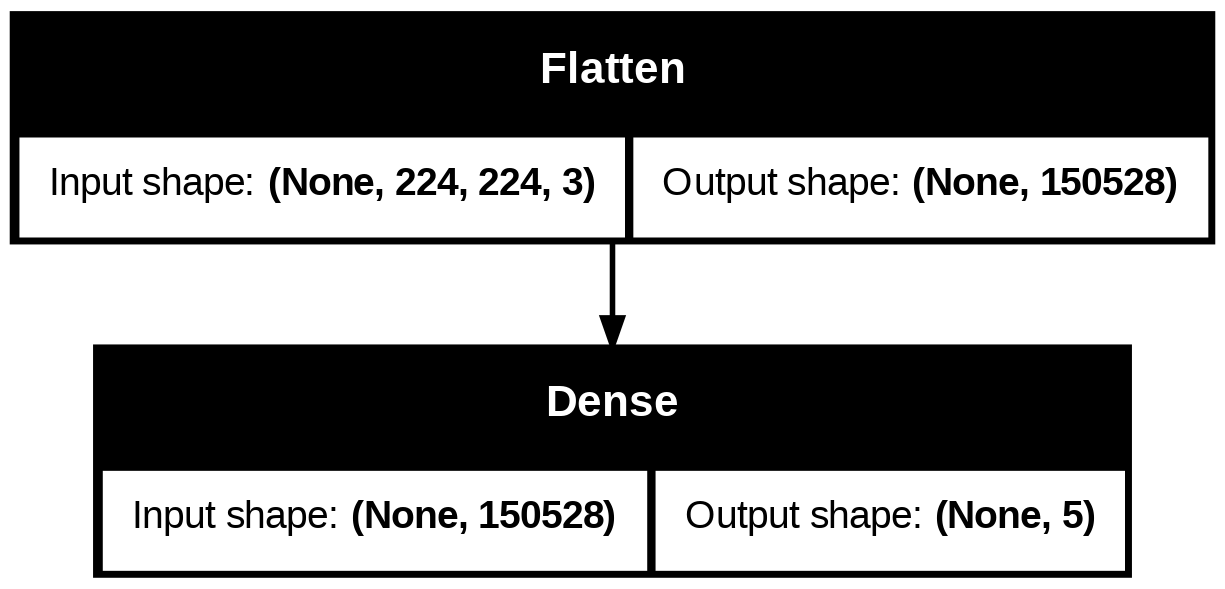

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
    330/Unknown 160s 475ms/step - accuracy: 0.3118 - loss: 17.5241

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


330/330 ━━━━━━━━━━━━━━━━━━━━ 178s 531ms/step - accuracy: 0.3118 - loss: 17.5180 - val_accuracy: 0.3216 - val_loss: 19.8899
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 168s 504ms/step - accuracy: 0.4099 - loss: 14.6947 - val_accuracy: 0.3649 - val_loss: 30.8680
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 167s 503ms/step - accuracy: 0.4583 - loss: 13.2123 - val_accuracy: 0.3676 - val_loss: 21.5050
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 167s 503ms/step - accuracy: 0.4808 - loss: 12.1563 - val_accuracy: 0.3622 - val_loss: 26.7225
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 166s 499ms/step - accuracy: 0.4668 - loss: 17.7873 - val_accuracy: 0.4081 - val_loss: 20.8007
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 165s 497ms/step - accuracy: 0.5304 - loss: 12.2154 - val_accuracy: 0.3919 - val_loss: 27.6448
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 164s 493ms/step - accuracy: 0.5472 - loss: 14.2977 - val_accuracy: 0.4081 - val_loss: 24.9604
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 164s 495ms/step - accuracy: 0.572

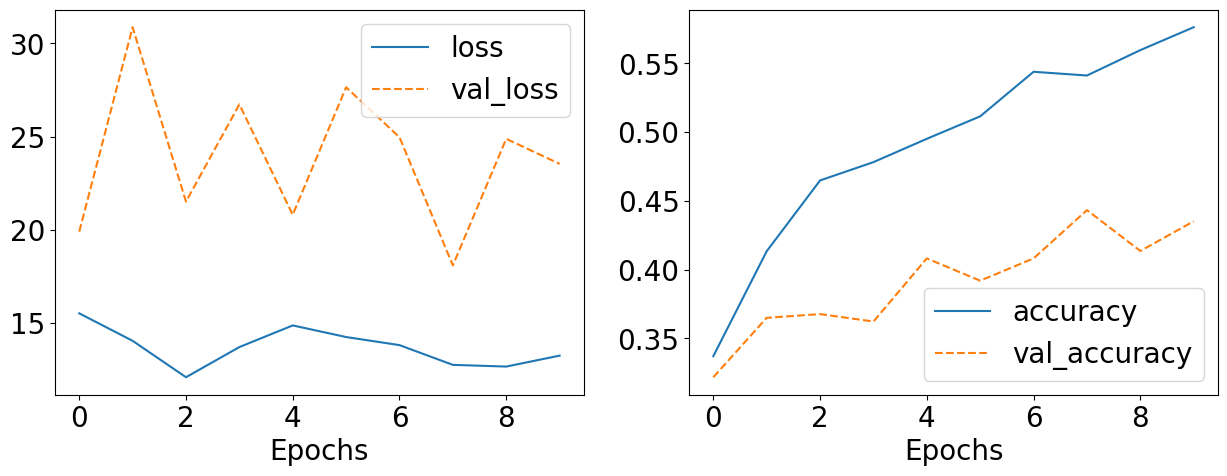

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

training_plot(['loss', 'accuracy'], history);

-  categorical cross-entropy - For one-hot encoded labels.  Loss: tf.keras.losses.CategoricalCrossentropy(from_logits=False)y

- If the labels are integer (1=diasy, etc) then decode_csv will represent the label class
label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string)) and Loss will be specified as
tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False).





In [ ]:
WHY HAVE TWO WAYS TO REPRESENT THE LABEL?
When we do one-hot encoding, we represent a flower that is a daisy as [1 0 0 0 0] and a flower that is a tulip as [0 0 0 0 1]. The length of the one-hot-encoded vector is the number of classes. The sparse representation would be 0 for daisy and 4 for tulip. The sparse representation takes up less space (especially if there are hundreds or thousands of possible classes) and is therefore much more efficient.

Why, then, does Keras support two ways to represent labels?

The sparse representation will not work if the problem is a multilabel multiclass problem. If an image can contain both daisies and tulips, it is quite straightforward to encode this using the one-hot-encoded representation: [1 0 0 0 1]. With the sparse representation, there is no way to represent this scenario unless you are willing to create separate categories for each possible combination of categories.

Therefore, we recommend you use the sparse representation for most problems; but remember that one-hot encoding the labels and using the CategoricalCrossentropy() loss function will help you handle multilabel multiclass situations.